<a href="https://colab.research.google.com/github/Steven-Macas/deepLearning_SAA/blob/main/deep_learning_parte3_steven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [4]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -n '/content/drive/MyDrive/archiveparte3.zip' >> /dev/null

In [7]:
# set variables 
main_folder = '../input/celeba-dataset/'
images_folder = 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = 'img_align_celeba/img_align_celeba/'+ '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 5
NUM_EPOCHS = 20

In [8]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [9]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

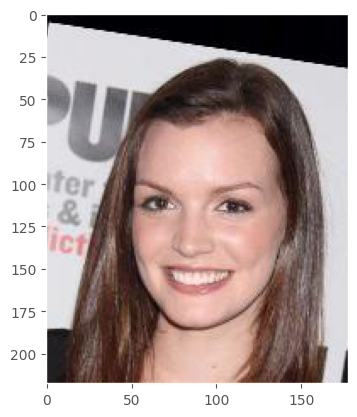

In [10]:
# plot picture and attributes
img = load_img('img_align_celeba/img_align_celeba/'+ '000506.jpg')
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

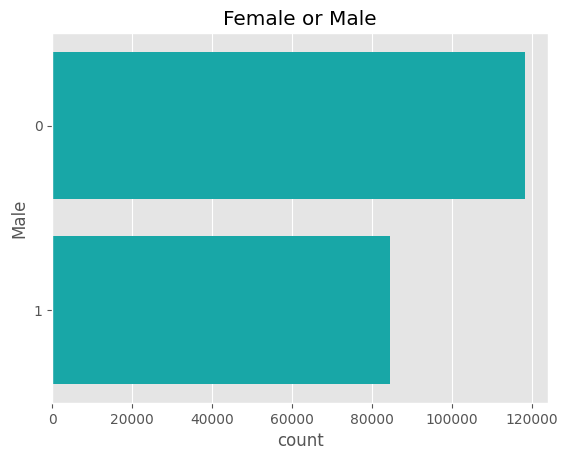

In [11]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [12]:
# Recomended partition
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [13]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [14]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [15]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

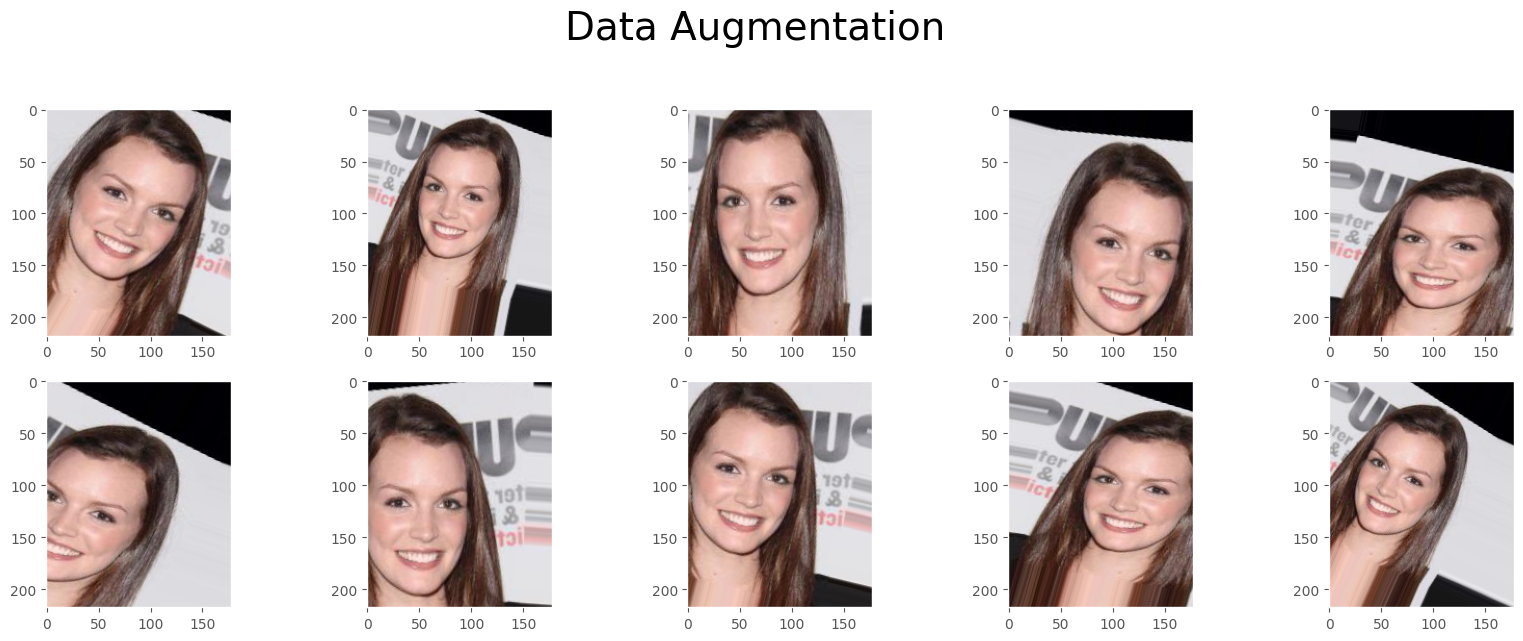

In [16]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2,  # esto es nuevo, reservamos un 20% de los datos para validación
# )

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [ ]:
#WARNING - Ejecutar solo si tienes más de 15 RAM mínimo
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [27]:
#WARNING - Ejecutar solo si tienes más de 15 RAM mínimo
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)
train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [17]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

In [19]:
# Import InceptionV3 Model
inc_model = InceptionV3(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
number of layers: 311


In [20]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [21]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [28]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

<ipython-input-28-e4e330739bfd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_.fit_generator(train_generator


Epoch 1/20
2000/2000 [==============================] - ETA: 0s - loss: 0.5896 - accuracy: 0.6739
Epoch 1: val_loss improved from inf to 0.69495, saving model to weights.best.inc.male.hdf5
2000/2000 [==============================] - 163s 72ms/step - loss: 0.5896 - accuracy: 0.6739 - val_loss: 0.6949 - val_accuracy: 0.5895
Epoch 2/20
2000/2000 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.7791
Epoch 2: val_loss did not improve from 0.69495
2000/2000 [==============================] - 134s 67ms/step - loss: 0.4700 - accuracy: 0.7791 - val_loss: 0.8412 - val_accuracy: 0.5100
Epoch 3/20
2000/2000 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8041
Epoch 3: val_loss did not improve from 0.69495
2000/2000 [==============================] - 133s 67ms/step - loss: 0.4291 - accuracy: 0.8041 - val_loss: 0.7031 - val_accuracy: 0.5650
Epoch 4/20
2000/2000 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8161
Epoch 4: val_lo

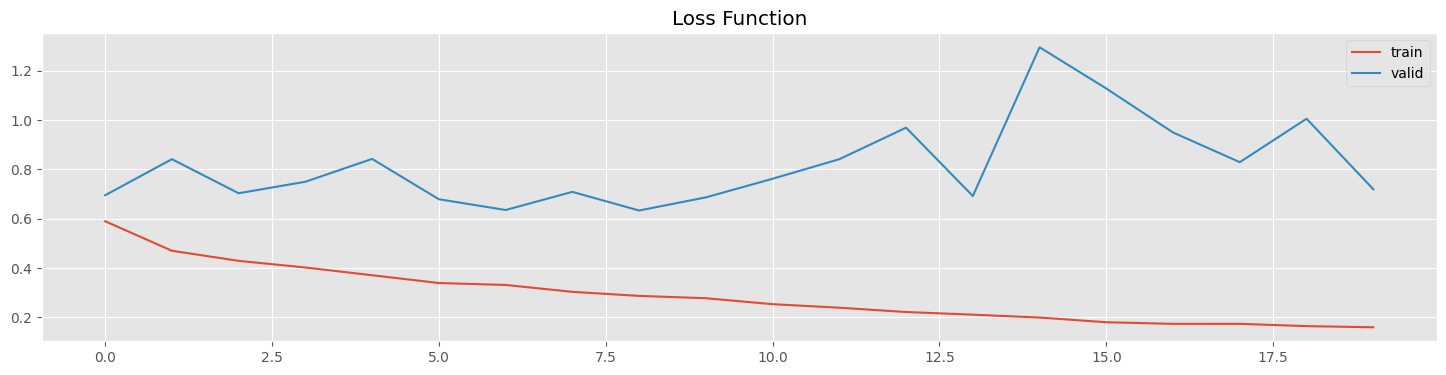

In [29]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

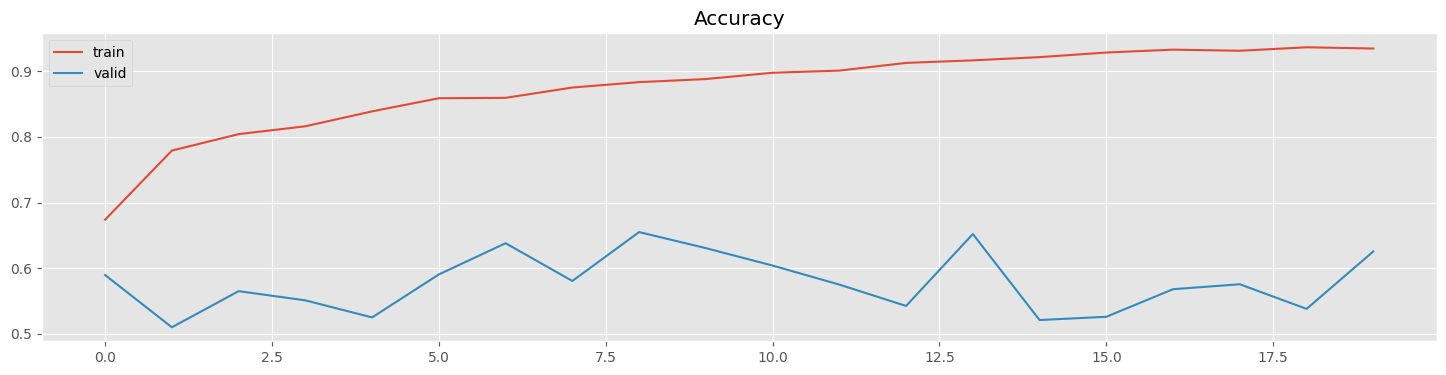

In [32]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [33]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [34]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

In [35]:
# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

1/1 [==============================] - 0s 28ms/step


In [36]:
# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 62.4500%
f1_score: 0.6963202587949859


In [39]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [40]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result

1/1 [==============================] - 0s 29ms/step



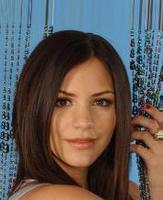

1/1 [==============================] - 0s 29ms/step



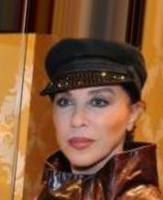

1/1 [==============================] - 0s 27ms/step



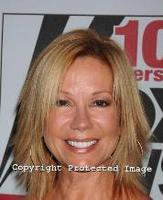

1/1 [==============================] - 0s 26ms/step



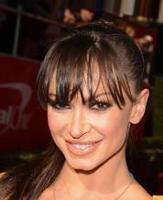

1/1 [==============================] - 0s 32ms/step



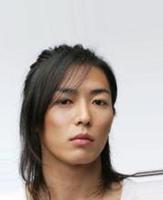

1/1 [==============================] - 0s 30ms/step



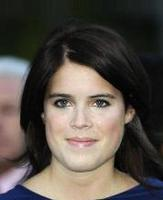

1/1 [==============================] - 0s 30ms/step



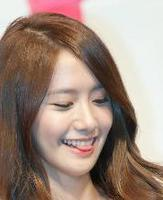

1/1 [==============================] - 0s 27ms/step



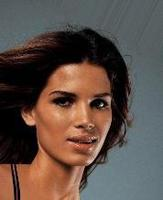

In [41]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['Male'])

# Conclusión

---



Los aspectos más relevantes de nuestra red neuronal:

Precisión del entrenamiento (accuracy): La precisión de la red neuronal en el conjunto de entrenamiento ha ido mejorando constantemente con cada época, comenzando desde el 67.39% en la primera época y alcanzando hasta un 93.45% en la época 20. Esto indica que la red está aprendiendo y mejorando su rendimiento en los datos de entrenamiento.

Pérdida de entrenamiento (loss): La pérdida de entrenamiento ha disminuido constantemente de 0.5896 en la primera época a 0.1599 en la última época. Este es otro indicador positivo de que la red está aprendiendo y mejorando su rendimiento en los datos de entrenamiento.

Precisión de validación (val_accuracy): La precisión en el conjunto de validación ha fluctuado a lo largo del entrenamiento, alcanzando un pico de 65.5% en la época 9 y luego disminuyendo hasta 62.55% en la época 20. Esto podría indicar un problema de sobreajuste, donde la red está aprendiendo demasiado bien los datos de entrenamiento, a expensas de su capacidad para generalizar a nuevos datos.

Pérdida de validación (val_loss): La pérdida de validación también ha fluctuado a lo largo del entrenamiento, alcanzando su punto más bajo de 0.63318 en la época 9 y luego aumentando hasta 0.7193 en la época 20. Este es otro indicador de posible sobreajuste.

En conclusión, la red parece estar aprendiendo y mejorando su rendimiento en los datos de entrenamiento. Sin embargo, también parece estar sufriendo de sobreajuste, ya que su rendimiento en el conjunto de validación no mejora de manera constante con cada época. 